In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import joblib

In [2]:
# Load the CNN model
cnn_model_path = r"C:\Users\K M SASTRY\Desktop\PROJECT\cnn_model.h5"
cnn_model = load_model(cnn_model_path)

# Extract the feature extraction part of the model (excluding the last classification layer)
feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-2].output)  # Use second-to-last layer


In [3]:
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image
    return img_array


In [4]:
# Set image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 32

# Prepare data generator for feature extraction (rescale images)
datagen = ImageDataGenerator(rescale=1.0/255)

# Load training data generator (for feature extraction)
data_dir = r"K:\PROJECT\ORGANISED DATASET"
train_generator = datagen.flow_from_directory(
    directory=f"{data_dir}/train",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 6185 images belonging to 2 classes.


In [5]:
# Extract features from the CNN model for the training data
X_train = feature_extractor.predict(train_generator)
y_train = train_generator.classes  # Labels

# Extract features for testing data
test_generator = datagen.flow_from_directory(
    directory=f"{data_dir}/test",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

X_test = feature_extractor.predict(test_generator)
y_test = test_generator.classes  # Labels


194/194 [==============================] - 122s 628ms/step
Found 1724 images belonging to 2 classes.
54/54 [==============================] - 34s 630ms/step


In [6]:
# Reshape the features to 2D (samples, features)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA for dimensionality reduction (optional)
pca = PCA(n_components=0.95)  # Retain 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


In [7]:
# Train the Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_pca, y_train)

RandomForestClassifier(random_state=42)

In [8]:
# Make predictions with the Random Forest classifier
y_pred = rf_clf.predict(X_test_pca)

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.72      0.73       542
           1       0.87      0.89      0.88      1182

    accuracy                           0.83      1724
   macro avg       0.81      0.80      0.81      1724
weighted avg       0.83      0.83      0.83      1724

Confusion Matrix:
[[ 389  153]
 [ 133 1049]]


In [9]:
# Save the trained Random Forest model for later use
joblib.dump(rf_clf, r"C:\Users\K M SASTRY\Desktop\PROJECT\cnn_+_rf_classifier.pkl")


['C:\\Users\\K M SASTRY\\Desktop\\PROJECT\\cnn_+_rf_classifier.pkl']

1/1 [==============================] - 0s 36ms/step


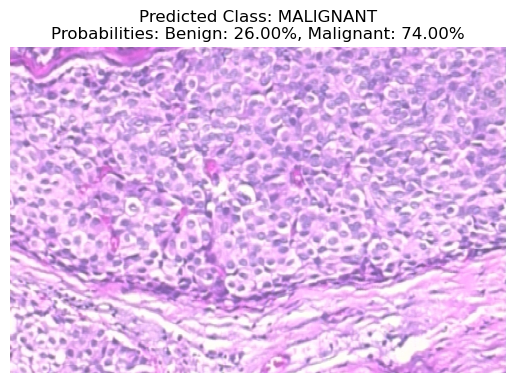

In [18]:
# Load the trained Random Forest model
rf_clf = joblib.load(r"C:\Users\K M SASTRY\Desktop\PROJECT\cnn_+_rf_classifier.pkl")

# Path to a test image
img_path = r"K:\PROJECT\ORGANISED DATASET\test\MALIGNANT\mucinous_carcinoma\SOB_M_MC_14-13413\100X\SOB_M_MC-14-13413-100-036.png"

# Preprocess the input image
input_image = preprocess_image(img_path, target_size=(img_height, img_width))

# Extract features using the CNN feature extractor
features = feature_extractor.predict(input_image)
features = features.reshape(1, -1)  # Reshape to fit the Random Forest input

# Standardize and apply PCA
features_scaled = scaler.transform(features)
features_pca = pca.transform(features_scaled)

# Make prediction using the trained Random Forest classifier
prediction = rf_clf.predict(features_pca)
prediction_proba = rf_clf.predict_proba(features_pca)

# Decode the predicted label
class_indices = train_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}
predicted_label = class_labels[prediction[0]]

# Format probabilities as percentages
prediction_proba_percent = prediction_proba[0] * 100

# Display the input image and prediction results
plt.imshow(image.load_img(img_path))
plt.axis('off')
plt.title(f"Predicted Class: {predicted_label}\n"
          f"Probabilities: Benign: {prediction_proba_percent[0]:.2f}%, "
          f"Malignant: {prediction_proba_percent[1]:.2f}%")
plt.show()


1/1 [==============================] - 0s 32ms/step


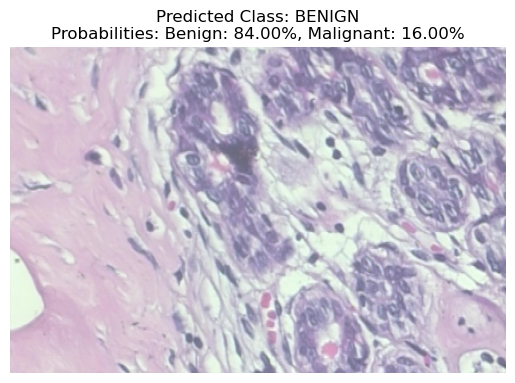

In [21]:
# Load the trained Random Forest model
rf_clf = joblib.load(r"C:\Users\K M SASTRY\Desktop\PROJECT\cnn_+_rf_classifier.pkl")

# Path to a test image
img_path = r"K:\PROJECT\ORGANISED DATASET\test\BENIGN\fibroadenoma\SOB_B_F_14-9133\200X\SOB_B_F-14-9133-200-026.png"

# Preprocess the input image
input_image = preprocess_image(img_path, target_size=(img_height, img_width))

# Extract features using the CNN feature extractor
features = feature_extractor.predict(input_image)
features = features.reshape(1, -1)  # Reshape to fit the Random Forest input

# Standardize and apply PCA
features_scaled = scaler.transform(features)
features_pca = pca.transform(features_scaled)

# Make prediction using the trained Random Forest classifier
prediction = rf_clf.predict(features_pca)
prediction_proba = rf_clf.predict_proba(features_pca)

# Decode the predicted label
class_indices = train_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}
predicted_label = class_labels[prediction[0]]

# Format probabilities as percentages
prediction_proba_percent = prediction_proba[0] * 100

# Display the input image and prediction results
plt.imshow(image.load_img(img_path))
plt.axis('off')
plt.title(f"Predicted Class: {predicted_label}\n"
          f"Probabilities: Benign: {prediction_proba_percent[0]:.2f}%, "
          f"Malignant: {prediction_proba_percent[1]:.2f}%")
plt.show()
